Solution Path (A*): [(0, 0), (0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (5, 8), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]
Solution Path (UCS): [(0, 0), (0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (5, 8), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]


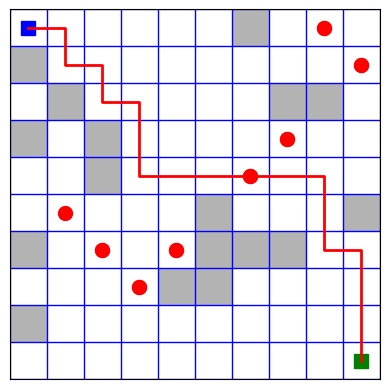

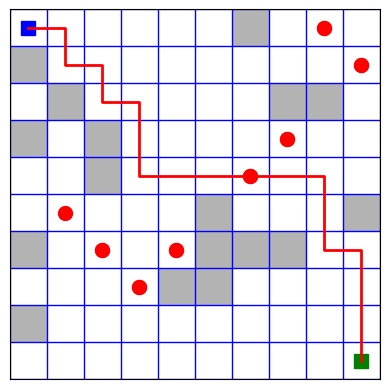

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq


class PriorityQueue:
    def __init__(self):
        self.elements = []


    def empty(self):
        return len(self.elements) == 0


    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))


    def get(self):
        return heapq.heappop(self.elements)[1]




class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, remaining_steps=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.remaining_steps = remaining_steps

    def __lt__(self, other):
        return self.path_cost < other.path_cost


def heuristic(a, b):
    """
    Calculate the Manhattan distance between two points a and b.


    Parameters:
    - a: Tuple representing the x and y coordinates of point a (e.g., (x1, y1))
    - b: Tuple representing the x and y coordinates of point b (e.g., (x2, y2))


    Returns:
    - The Manhattan distance between points a and b.
    """
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)




class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.initial = start
        self.goal = goal



    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state



        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')


        return possible_actions



    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)



    def is_goal(self, state):
        return state == self.goal


class Agent:
    def __init__(self, env):
        self.env = env


    def a_star_search(self):

        start_node = Node(self.env.initial, path_cost=0, remaining_steps=self.get_manhattan_distance(self.env.initial, self.env.goal))
        frontier = PriorityQueue()
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}


        while not frontier.empty():
            current_node = frontier.get()


            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)


            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)  # f-cost = g-cost + h-cost
                    remaining_steps = self.get_manhattan_distance(new_state, self.env.goal)
                    frontier.put(Node(new_state, current_node, action, new_cost, remaining_steps), priority)
                    came_from[new_state] = current_node.state


                    # Check if the battery needs recharging and add the charging point to the list
                    if self.needs_recharge(new_state, new_cost):
                        self.add_charging_point(new_state)


        return []


    def uniform_cost_search(self):
        frontier = PriorityQueue()  # Priority queue for UCS.
        frontier.put(Node(self.env.initial, path_cost=0, remaining_steps=self.get_manhattan_distance(self.env.initial, self.env.goal)), 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}


        while not frontier.empty():
            current_node = frontier.get()


            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)


            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity; adjust if varying costs.
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost
                    remaining_steps = self.get_manhattan_distance(new_state, self.env.goal)
                    frontier.put(Node(new_state, current_node, action, new_cost, remaining_steps), priority)
                    came_from[new_state] = current_node.state


                    # Check if the battery needs recharging and add the charging point to the list
                    if self.needs_recharge(new_state, new_cost):
                        self.add_charging_point(new_state)


        return []


    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.initial)  # Start node is not in came_from
        path.reverse()  # Reverse to get the path from start to goal
        return path


    def needs_recharge(self, state, steps):
        # Add charging point if the remaining steps to the goal is a multiple of 10 and the charge is 0%
        return steps % 10 == 0 and steps != 0


    def add_charging_point(self, point):
        if not hasattr(self, 'charging_points'):
            self.charging_points = []
        self.charging_points.append(point)


    def get_manhattan_distance(self, a, b):

        (x1, y1) = a
        (x2, y2) = b
        return abs(x1 - x2) + abs(y1 - y2)


# Visualization Function plots the grid and the found path.
def visualize_grid_and_path(grid, path, charging_points):
    grid_array = np.array(grid)
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0.3)
    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'bs', markersize=10)
    ax.plot(goal[1], goal[0], 'gs', markersize=10)
    xs, ys = zip(*path)
    ax.plot(ys, xs, 'r-', linewidth=2)



    for point in charging_points:
        ax.plot(point[1], point[0], 'ro', markersize=10)


    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()




grid_size = 10
obstacle_probability = 0.2




grid = np.random.choice([0, 1], size=(grid_size, grid_size), p=[1-obstacle_probability, obstacle_probability])




start = (0, 0)
goal = (grid_size - 1, grid_size - 1)




grid[start] = 0
grid[goal] = 0




environment = Environment(grid, start, goal)
agent = Agent(environment)




solution_path_astar = agent.a_star_search()
print("Solution Path (A*):", solution_path_astar)




solution_path_ucs = agent.uniform_cost_search()
print("Solution Path (UCS):", solution_path_ucs)




visualize_grid_and_path(grid, solution_path_astar, agent.charging_points)
visualize_grid_and_path(grid, solution_path_ucs, agent.charging_points)




